##### This script writes data from the sequence of the frames in jpg files and numerical data in csv files to the tfrecords files to later feed into model for training. One file contane all frames of the video. While parsing the small sequence of time ordered frames will be randomly chosen from the tfrecords file.

In [1]:
#%%writefile create_tf_dataset.py
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from random import shuffle,sample
import math
from tqdm import tqdm
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

##### This cell constructs the list of all videonames from corresponding directories names in the dir "frames/". After that, it creates a dictionary containing video names as a keys and list of frame names in chronological order from the video as a values

In [2]:
working_directory = '../Data_samples/train data/frames/'
video_names=list(os.walk(working_directory))[0][1]

def frames_order(frame):
    return int(''.join(list(filter(str.isdigit, frame))))

framenames = {video_name: 
                  sorted([frame for frame in os.listdir(working_directory + video_name) if frame.endswith('jpg')],key=frames_order)
                  for video_name in video_names}

In [3]:
framenames

{'video_ion0': ['fr-0.jpg',
  'fr-1.jpg',
  'fr-2.jpg',
  'fr-3.jpg',
  'fr-4.jpg',
  'fr-5.jpg',
  'fr-6.jpg',
  'fr-7.jpg',
  'fr-8.jpg',
  'fr-9.jpg'],
 'video_ion1': ['fr-0.jpg',
  'fr-1.jpg',
  'fr-2.jpg',
  'fr-3.jpg',
  'fr-4.jpg',
  'fr-5.jpg',
  'fr-6.jpg',
  'fr-7.jpg',
  'fr-8.jpg',
  'fr-9.jpg'],
 'video_ion2': ['fr-0.jpg',
  'fr-1.jpg',
  'fr-2.jpg',
  'fr-3.jpg',
  'fr-4.jpg',
  'fr-5.jpg',
  'fr-6.jpg',
  'fr-7.jpg',
  'fr-8.jpg',
  'fr-9.jpg'],
 'video_ion3': ['fr-0.jpg',
  'fr-1.jpg',
  'fr-2.jpg',
  'fr-3.jpg',
  'fr-4.jpg',
  'fr-5.jpg',
  'fr-6.jpg',
  'fr-7.jpg',
  'fr-8.jpg',
  'fr-9.jpg'],
 'video_ion4': ['fr-0.jpg',
  'fr-1.jpg',
  'fr-2.jpg',
  'fr-3.jpg',
  'fr-4.jpg',
  'fr-5.jpg',
  'fr-6.jpg',
  'fr-7.jpg',
  'fr-8.jpg',
  'fr-9.jpg'],
 'video_tg5': ['fr-0.jpg',
  'fr-1.jpg',
  'fr-2.jpg',
  'fr-3.jpg',
  'fr-4.jpg',
  'fr-5.jpg',
  'fr-6.jpg',
  'fr-7.jpg',
  'fr-8.jpg',
  'fr-9.jpg'],
 'video_tg6': ['fr-0.jpg',
  'fr-1.jpg',
  'fr-2.jpg',
  'fr-3.jpg',
  

In [4]:
seq_len=5
video_names=list(framenames.keys())
shuffle(video_names)

sample_list=[]
for key in video_names:
    for n in range(len(framenames[key])//seq_len):
        sample_list.append([key,framenames[key][n*seq_len:(n+1)*seq_len]])
shuffle(sample_list)

In [5]:
sample_list

[['video_tg6', ['fr-5.jpg', 'fr-6.jpg', 'fr-7.jpg', 'fr-8.jpg', 'fr-9.jpg']],
 ['video_tg8', ['fr-5.jpg', 'fr-6.jpg', 'fr-7.jpg', 'fr-8.jpg', 'fr-9.jpg']],
 ['video_ion0', ['fr-0.jpg', 'fr-1.jpg', 'fr-2.jpg', 'fr-3.jpg', 'fr-4.jpg']],
 ['video_ion1', ['fr-0.jpg', 'fr-1.jpg', 'fr-2.jpg', 'fr-3.jpg', 'fr-4.jpg']],
 ['video_tg5', ['fr-5.jpg', 'fr-6.jpg', 'fr-7.jpg', 'fr-8.jpg', 'fr-9.jpg']],
 ['video_ion4', ['fr-5.jpg', 'fr-6.jpg', 'fr-7.jpg', 'fr-8.jpg', 'fr-9.jpg']],
 ['video_tg7', ['fr-5.jpg', 'fr-6.jpg', 'fr-7.jpg', 'fr-8.jpg', 'fr-9.jpg']],
 ['video_tg9', ['fr-5.jpg', 'fr-6.jpg', 'fr-7.jpg', 'fr-8.jpg', 'fr-9.jpg']],
 ['video_ion2', ['fr-0.jpg', 'fr-1.jpg', 'fr-2.jpg', 'fr-3.jpg', 'fr-4.jpg']],
 ['video_ion1', ['fr-5.jpg', 'fr-6.jpg', 'fr-7.jpg', 'fr-8.jpg', 'fr-9.jpg']],
 ['video_ion3', ['fr-5.jpg', 'fr-6.jpg', 'fr-7.jpg', 'fr-8.jpg', 'fr-9.jpg']],
 ['video_tg5', ['fr-0.jpg', 'fr-1.jpg', 'fr-2.jpg', 'fr-3.jpg', 'fr-4.jpg']],
 ['video_tg9', ['fr-0.jpg', 'fr-1.jpg', 'fr-2.jpg', 'fr-3.

##### this cell creates dataframe of labels from csv files. The names of the videos are indecies in this DF.

In [6]:
dfs=[pd.read_csv(filepath_or_buffer = working_directory + name,index_col=0) for name in os.listdir(working_directory) if name.endswith('csv')]
labels_df=pd.concat(dfs)

##### Following two cells add weights for every label. These weights are used to balance the unbalanced dataset in both average wind and wind gust, two weights per sample. The weigts are calculated as 1/n, where n is number of samples with value w_(i) < w < w_(i+1). The w_i and w_i+1 are the integer estimates from abow and from below of a value w. In this way the more samples we have for particular value w the less is the contribution of this sample into loss function.

In [7]:
top_avg=math.ceil(labels_df['avg. wind'].max()) #ceiling value for avg.wing
labels=[i+1 for i in range(0,top_avg,1)] #labels for binns 
binned1 = pd.cut(labels_df['avg. wind'],range(1+top_avg),labels=labels) #creating the binned series from the avg.wind values
labels_df['w1'] = [1./binned1.value_counts()[i] for i in binned1]  #calculating the weights as 1/n. Where n is number of samples in a given bin
labels_df['w1'] = labels_df['w1']/labels_df['w1'].mean() #normalizing weights such that summ of w_i = 1.

In [8]:
# same as previous cell but for wind.gust values
top_gust = math.ceil(labels_df['wind gust'].max())
labels=[i+1 for i in range(0,top_gust,1)]
binned2 = pd.cut(labels_df['wind gust'],range(1+top_gust),labels=labels)
labels_df['w2'] = [1./binned2.value_counts()[i] for i in binned2]
labels_df['w2'] = labels_df['w2']/labels_df['w2'].mean()

In [9]:
labels_df

,avg. wind,wind gust,w1,w2
video_ion0,14.2,18.2,0.833333,0.625
video_ion1,14.2,17.8,0.833333,2.500
video_ion2,14.8,19.0,0.833333,0.625
video_ion3,13.4,19.0,1.250000,0.625
video_ion4,13.4,18.4,1.250000,0.625
video_tg5,14.2,18.2,0.833333,0.625
video_tg6,14.2,17.8,0.833333,2.500
video_tg7,14.8,19.0,0.833333,0.625
video_tg8,13.4,19.0,1.250000,0.625
video_tg9,13.4,18.4,1.250000,0.625


##### Auxilary functions for writing values into tfrecord files. They create features of different types from the values

In [10]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _float64_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _bytes_list_feature(values):
    """Wrapper for inserting bytes features into Example proto."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=values))

##### This cell writes datasets into tfrecord files. Each file contains a set of samples (number_of_samples=length_of_video/seq_len). Each sample contains 1) sequence of seq_len frames from this video in jpg encoding, written as a byte string, 2) label - a np.array of two float64 numbers 3)name of the video - a sting type

In [11]:
tfrecord_dir = '../Data_samples/train data/tfrecords_seq'
try: 
    os.mkdir(tfrecord_dir)
except FileExistsError:
    pass

filename = tfrecord_dir + '/train{}.tfrecords' #the base for addresses to save the TFRecords files  


In [12]:

n=0 #this is the counter is to count every 100 samples to start new tfrecords file

for sample in sample_list:    
    
    video_name = sample[0]
    frame_list = sample[1]
    
    if n%100 == 0:
        #every 100 samples a new tfrecords file is opened, to avoid huge files
        writer = tf.python_io.TFRecordWriter(filename.format(n//100))
      
    seq=[]
    for frame in frame_list:
        with open(working_directory+video_name+'/'+frame,'rb') as file:
            img=file.read() #read the image
            seq.append(img) #append image into a list containing the sequence
            
    labels_weights = np.array(labels_df.loc[video_name]) #read label for a given video file
    
    # Create a feature
    feature = {'train/labels_weights': _float64_feature(labels_weights),
                'train/seq': _bytes_list_feature(seq),
                'train/seq_len': _int64_feature([seq_len])}
            
    # Create an example protocol buffer
    example = tf.train.Example(features=tf.train.Features(feature=feature))

    # Serialize to string and write on the file
    writer.write(example.SerializeToString())
    
    n+=1
    if n%100==0:
        writer.close()

### Tests, Checking that written dataset is readable and correct

##### This cell contains parsing function to decode serialized samples read from tfrecord file. It returns tuple of tf.tensors of 1) image in format (width,height,color_chanel), 2)label - array of two numbers and 3) name of the video as a string type

In [21]:
def _parse_function(example_proto,seq_num):
    
    feature = {'train/seq': tf.VarLenFeature(tf.string),
               'train/seq_len': tf.FixedLenFeature((1,),tf.int64),
               'train/labels_weights': tf.FixedLenFeature((4,), tf.float32)}
    parsed_features = tf.parse_single_example(example_proto, features=feature)
    print(parsed_features["train/seq_len"])
    #random_offset defines the first frame in a sample sequence 
    random_offset = tf.random_uniform(
        shape=(), minval=0,
        maxval=parsed_features["train/seq_len"][0] - seq_num, dtype=tf.int64)
    
    #offset defines the sequence itself from the first to seq_num frame    
    offsets = tf.range(random_offset,random_offset + seq_num,dtype=tf.int64)

    #get sequence of frames and decode jpg into first uint8 and then normalize by 1/255. and convert to float32 type
    seq = tf.map_fn(lambda i: tf.cast(tf.image.decode_jpeg(parsed_features['train/seq'].values[i])[:448,:704,:],tf.int64)
                    ,offsets)
    
    seq = tf.cast(seq,tf.float32)/255.
    
    #get label for a sequence of frame (labals are all the same for the whole video)
    labels_weights = parsed_features['train/labels_weights']
    labels = labels_weights[0:2]
    weights = labels_weights[2:]
   
    
    return seq, labels,weights #, shapeseq_len, , name

#a wrapper function to pass seq_num parameter into parser
def _parse_function_param(seq_num):
    def parse(example_proto):
        return _parse_function(example_proto,seq_num)
    return parse

##### this cell create dataset from the list of tfrecord files

In [22]:
#filenames = ['train_{}.tfrecords'.format(vn) for vn in video_names]

filenames = [tfrecord_dir+'/'+file for file in os.listdir(tfrecord_dir) if file.endswith('tfrecords')]

In [29]:
dataset = tf.data.TFRecordDataset(filenames)
dataset = dataset.map(_parse_function_param(3))

Tensor("ParseSingleExample/ParseSingleExample:4", shape=(1,), dtype=int64)


In [30]:
filenames

['../Data_samples/train data/tfrecords_seq/train0.tfrecords']

##### This cell create iterator to deliver data into graph for training

In [31]:
dataset = dataset.repeat(1)
dataset = dataset.batch(1)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()


##### Read and check the data

In [32]:
sess=tf.InteractiveSession()

C:\Users\ttnnn\Anaconda3\lib\site-packages\tensorflow\python\client\session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [33]:
sess.run(iterator.initializer)

In [34]:
value,labels,weights = sess.run(next_element)



#print(value)
#plt.imshow(value[0][0])

In [35]:
labels

array([[14.2, 17.8]], dtype=float32)

In [36]:
def plotiterator():
    for i in range(value.shape[1]):
        yield plt.imshow(np.squeeze(value[0])[i])

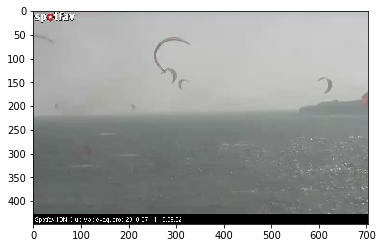

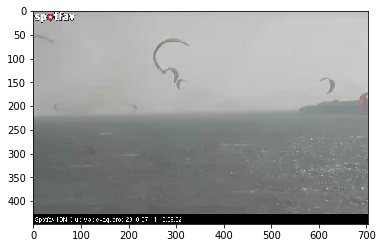

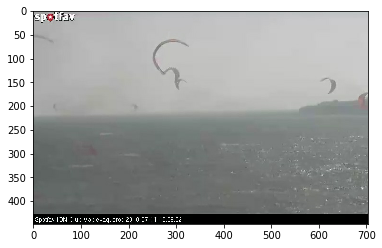

In [37]:
for plot in plotiterator():
    plt.show()